# MNIST Digit Recognition Using Least Squares Problem

---
#### Course: Computational Data Mining
#### Professor: Dr. Fatemeh Shakeri
#### Student: Ilya Khalafi
#### Student ID: 9913039
#### November 2023

# Table Of Contents
- [Introduction](#intro)
- [Dependencies](#dependency)
- [Import Dataset](#read)
  - [Download MNIST Dataset](#download)
  - [Import Addresses](#addresses)
  - [Import Images](#images)
- [Implementation](#implementation)
    - [QR Decomposition Using Householders](#qr)
    - [Solve LSP Using QR Decomposition](#solve)
    - [Implement LSP for Prediction](#lsp)
    - [Predict Digit for each Image](#pred)
- [Analyze the Method's Performance](#performance)

<a name="intro"></a>

# Introduction 📚

---

The MNIST database is a well-known dataset in computer vision that includes handwritten digits of 0 to 9.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f7/MnistExamplesModified.png/320px-MnistExamplesModified.png" width="500"/>

In this article, we convert matrix of each image to a vector and for each digit, we define a space using vector of that digit. Then, we find closest coordination of our new image in each space and label our image with the digit that has closest coordination using the well-known least squares problem.

<a name="dependency"></a>

#Dependencies 🧰

---

We need the following libraries during this article:

- **os** : <br />
    os is among python's standard libraries. We use it to browser directories and import images.

- **numpy** : <br />
    numpy is a commonly used library for doing scientific computation. Unlike python default pointer structure, numpy saves variables inplace and continous on RAM and also provides sophisticated methods that use parallelism to make our computations much faster.

- **PIL**: <br />
    PIL or Pillow library is a common well-known library for image processing. It helps us to read, manipulate and save images. We will use it together with OpenCV.

- **matplotlib** : <br />
    Matplotlib is a well-known library in data science for visualization. We will use matplotlib to demonstrate our results.

- **seaborn** : <br />
    seaborn is built on matplotlib and provides many chart templates for us so we don't need to draw and build every components of our charts with matplotlib.

- **scikit-learn (sklearn)** : <br />
    This library is a known data science library and we will import iris dataset from it and also some metric methods as well.

- **cv2** : <br />
    OpenCV or cv2 is probably the most well-known and the most useful python library for image and video processing.

In [1]:
%%capture
# Python Standard Libraries
import os
import random
# Fundamental Data & Image Analysis Tools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from PIL import Image
import cv2

<a name="read"></a>

#Importing Dataset 🖼

---

First, we import our dataset from my google drive using gdown.


<a name="download"></a>

####Downloading the Dataset

Lets download our dataset.


In [ ]:
# Download the dataset
!gdown 'ٰ1YIHYl3F7lvjWqH03gy4KShK4sR_i16yv'

Now we unpack our dataset.

In [12]:
%%capture
# Unpack the Dataset
!unzip '/content/TinyMNIST.zip'

<a name="addresses"></a>

####Import Addresses

Here we import address of train and test images.

In [2]:
# Defining Directories
train_dr = os.path.join('TinyMNIST', 'train')
test_dr = os.path.join('TinyMNIST', 'test')
# Browsing Train Directory
train_folders = [addr for addr in os.listdir(train_dr)]
train_paths = {int(folder): [os.path.join(train_dr, folder, path) for path in os.listdir(os.path.join(train_dr, folder))] for folder in train_folders}
# Browsing Test Directory
test_folders = [addr for addr in os.listdir(test_dr)]
test_paths = {int(folder): [os.path.join(test_dr, folder, path) for path in os.listdir(os.path.join(test_dr, folder))] for folder in test_folders}
# Print Success Message
print('Successfully Imported Addresses!')

Successfully Imported Addresses!


Lets demonstrate a random photo for a quick preview!

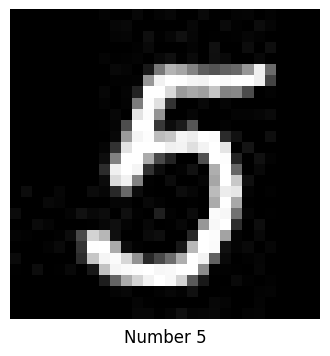

In [3]:
# Selecting a Random Image
num = random.randint(0, 9)
sample_img = np.array(Image.open(random.choice(train_paths[num])))
# Displaying the Image
plt.figure(figsize=(4,8))
plt.axis('off')
plt.title(f'Number {num}', y=-0.1)
plt.imshow(sample_img, cmap='gray')

<a name="images"></a>

####Import Images

Finally, we must first import images from imported addresses into numpy dataframes.

In [64]:
train_imgs = {}
test_imgs = {}

# Importing Training Images and Converting to Numpy Array
for key in train_paths.keys():
    train_imgs[key] = np.zeros((28*28, len(train_paths[key])))
    for idx, addr in enumerate(train_paths[key]):
        train_imgs[key][:, idx] = np.array(Image.open(random.choice(train_paths[num]))).flatten()

# Importing Test Images and Converting to Numpy Array
for key in test_paths.keys():
    test_imgs[key] = np.zeros((28*28, len(test_paths[key])))
    for idx, addr in enumerate(test_paths[key]):
        test_imgs[key][:, idx] = np.array(Image.open(random.choice(test_paths[num]))).flatten()
        
print('Successfully Imported Images into Dataframes!')

Successfully Imported Images into Dataframes!


<a name="implementation"></a>

#Implementation 🧭

---


We will implement and test the performance of solving the least squares problem for each image and images of each digits. For each image, we assign it the digit that has the least norm of remainder vector.

<a name="qr"></a>

####QR Decomposition Using Householders

First, we define a method that calculates QR decomposition of a given matrix using householder matrices.

In [108]:
def qr_decomp(matrix):
    m, n = matrix.shape
    Q = np.eye(m)  # Initialize Q as an identity matrix
    R = matrix.copy()  # Initialize R with the input matrix
    
    for j in range(min(m, n)):
        x = R[j:, j]  # Column vector of R from j-th row to the end
        e = np.zeros_like(x)
        e[0] = np.sign(x[0] or 1)  # Create the sign vector
        
        v = x + np.linalg.norm(x) * e  # Householder vector
        v = v / np.linalg.norm(v)  # Normalize the Householder vector
        
        Qj = np.eye(m)  # Initialize the Householder matrix as identity matrix
        Qj[j:, j:] -= 2.0 * np.outer(v, v)  # Construct the Householder matrix
        
        Q = np.dot(Q, Qj.T)  # Multiply Q with the transpose of the Householder matrix
        R = np.dot(Qj, R)  # Multiply the Householder matrix with R
        
    return Q, R

Before going to the next part, we check output of our method to make sure our algorithm works.

In [66]:
# Define an example matrix
A = np.array([[-2,1,0], [1,-2,1], [0,1,-2]])
# Calculate differences of outputs for Q and R matrices
q, r = qr_decomp(A)
# Print norm of the remainder matric
print(f"Frobenius norm of the remainder matrix: {np.linalg.norm(q @ r - A, 'fro')}")
print(f"Frobenius norm of the I - Q * Q^T: {np.linalg.norm(q @ q.T - np.eye(q.shape[0], q.shape[1]), 'fro')}")

Frobenius norm of the remainder matrix: 7.139472397743243e-16
Frobenius norm of the I - Q * Q^T: 3.8773938153541794e-16


Awesome! Our method has near-zero error with the original numpy implementation. Please notice that error is very small and seemingly it is due to the underlying numerical errors.

<a name="solve"></a>

####Solve LSP Using QR Decomposition

Next, we define a method that solves the least squares problem using the QR decomposition from the previous methods. In order to solve the least squares problem of A\*x=b, we use QR decomposition of A which changes our equation to Q\*R\*x=b and by multiplying Q^T from left on each side we reach to the final equation of R\*x = Q^T\*b which is a upper triangular linear system and we can easily solve it. I know that the matrix R may not be full-rank, but we can use pseudo inverse which is defined for all matrices.

In [73]:
def solve_lsp(A, b, Q, R):
    bp = Q.T.dot(b)

    x = np.linalg.pinv(R) @ bp
    residual = np.dot(A, x) - b

    return x, residual

Now lets test our implemented method...

In [86]:
A = np.array([[1, 2], [3, 4], [5, 6]])
b = np.array([7, 8, 9])

Q, R = qr_decomp(A)
x, res = solve_lsp(A, b, Q, R)
print('Vector x: ', x)
print('Residual vector: ', res)

Vector x:  [-6.   6.5]
Residual vector:  [-1.77635684e-15 -3.55271368e-15 -7.10542736e-15]


By checking the solution, you will see that the vector [-6, 6.5] is in fact the solution of the above system; therefore, it seems our method works.

<a name="lsp"></a>

####Implement LSP for Prediction

To complete our pipeline, we define a method that applies the mentioned algorithm on a given image and returns the predicted digit for the given image.

In [93]:
def calc_min_residual(imgs, digits_train, digits_Q, digits_R):
    norms = np.zeros((10, imgs.shape[1]))
    for digit, arr in digits_train.items():
        Q = digits_Q[digit]
        R = digits_R[digit]
        _, res = solve_lsp(arr, imgs, Q, R)
        norms[int(digit)] = np.sum(res * res, axis=0)
        
    return np.argmin(norms, axis=0)

Please pay attention that we implement our code in a vectorized manner. The solve_lsp function takes matrices A, Q, R and a vector b and tries to find the vector with the least squares error but it does not care about b being a vector! Therefore, we send array of test images completely to boost performance of our implementation.

<a name="pred"></a>

####Predict Digit for each Image

Finally, we apply our implemented method on each test image to predict a digit for it.  We store our number of predictions in a confusion matrix which is in fact a 2D list and we return it from our function.

In [91]:
def predict(train_imgs, test_imgs, qr_method, frac=1):
    '''
    train_imgs (dict) : a dictionary from digits to np array of their images
    test_imgs (dict) : a dictionary from digits to np array of their images
    qr_method (function) : method to use for QR decomposition
    frac : fraction of the training set to use for predictions
    '''
    # Building training set and QR decomposition for each array of each digits
    train_set = {}
    Qs, Rs = {}, {}
    for digit, arr in train_imgs.items():
        train_size = int(frac * train_imgs[digit].shape[1])
        train_size = train_size if train_size > 0 else 1
        train_set[digit] = train_imgs[digit][:, :train_size]
        
        Q, R = qr_method(train_set[digit])
        Qs[digit] = Q
        Rs[digit] = R
        
    conf_mat = np.zeros((10, 10))
    for digit in test_imgs.keys():
        pred = calc_min_residual(test_imgs[digit], train_set, Qs, Rs)
        for val in pred:
            conf_mat[digit][val] += 1
    
    return conf_mat

<a name="performance"></a>

#Analyze the Method's Performance

---

Finally, we answer two problems that are mentioned in HW4:

- 1) Compare the accuracy of the algorithm while using our QR method and the QR method in numpy library.
- 2) Test the algorithm's accuracy with different amount of training images.

Here we answer the first question. We use our QR method and numpy's QR method for digit recognition, and then we plot confusion matrices for each approach.

In [ ]:
my_conf_mat = predict(train_imgs, test_imgs, qr_method = qr_decomp)
np_conf_mat = predict(train_imgs, test_imgs, qr_method = np.linalg.qr)

[Text(0.5, 1.0, 'Difference of Confusion Matrices')]

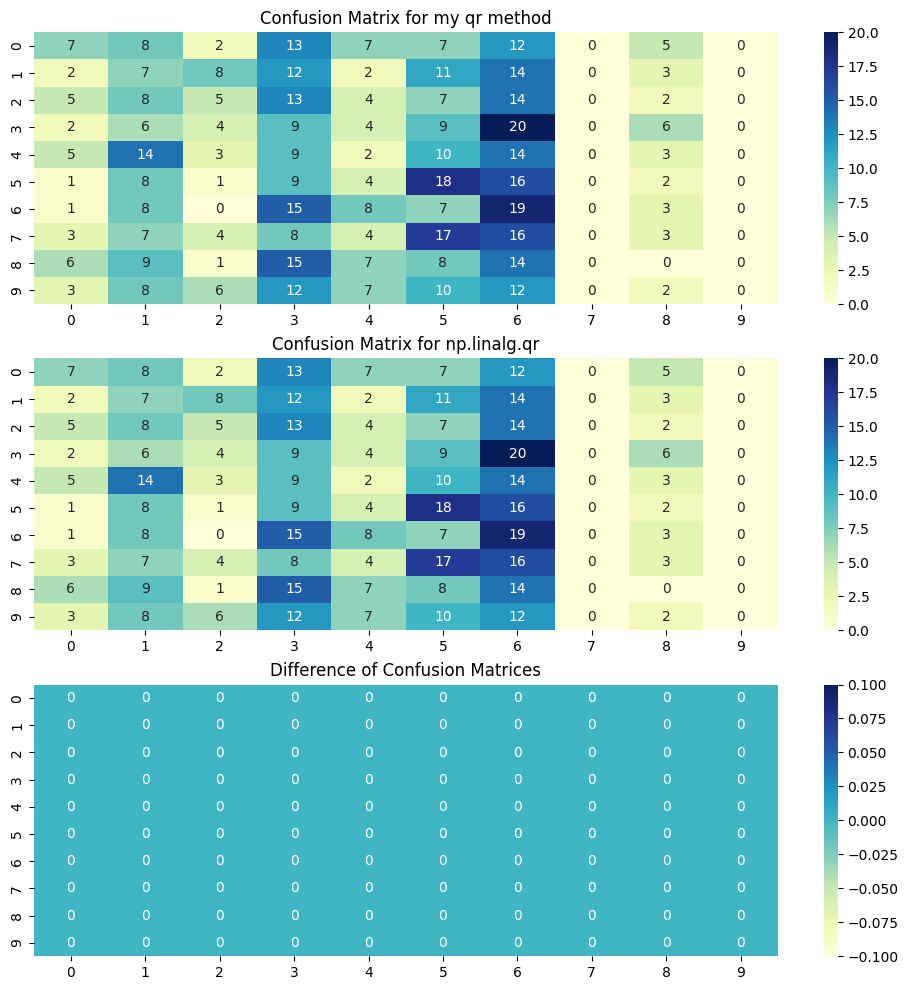

In [103]:
# Plotting our confusion matrices
plt.figure(figsize=(12, 12))

plt.subplot(3, 1, 1)
sns.heatmap(my_conf_mat, annot=True, cmap='YlGnBu').set(title='Confusion Matrix for my qr method')

plt.subplot(3, 1, 2)
sns.heatmap(np_conf_mat, annot=True, cmap='YlGnBu').set(title='Confusion Matrix for np.linalg.qr')

plt.subplot(3, 1, 3)
sns.heatmap(np.abs(my_conf_mat - np_conf_mat), annot=True, cmap='YlGnBu').set(title='Difference of Confusion Matrices')

You can observe that our implemented qr method shows similar output in our algorithm to np.linalg.qr method.

Now, we aim to answer the second question. We test our algorithm with 33, 67 and 100 percent of the training images for each digits and plot results.

In [ ]:
first_conf_mat = predict(train_imgs, test_imgs, qr_method = np.linalg.qr, frac = .33)
second_conf_mat = predict(train_imgs, test_imgs, qr_method = np.linalg.qr, frac = .67)
# third_conf_mat = we have previously calculated this matrix for 100 percent of our training images

[Text(0.5, 1.0, 'Confusion Matrix Using 100% of training images')]

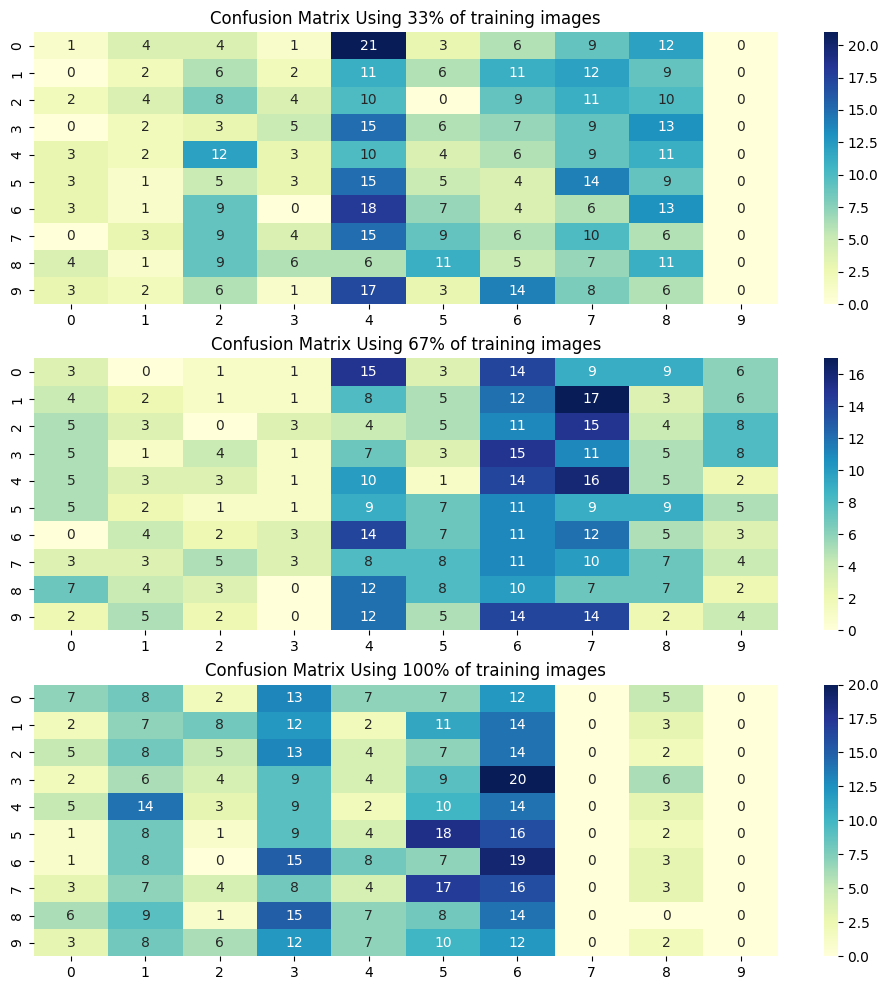

In [106]:
# Plotting our confusion matrices
plt.figure(figsize=(12, 12))

plt.subplot(3, 1, 1)
sns.heatmap(first_conf_mat, annot=True, cmap='YlGnBu').set(title="Confusion Matrix Using 33% of training images")

plt.subplot(3, 1, 2)
sns.heatmap(second_conf_mat, annot=True, cmap='YlGnBu').set(title="Confusion Matrix Using 67% of training images")

plt.subplot(3, 1, 3)
sns.heatmap(np_conf_mat, annot=True, cmap='YlGnBu').set(title="Confusion Matrix Using 100% of training images")

We expect to get higher accuracy by adding new training images, because we get more datapoints in our space and therefore there is a higher chance that we find a linear combination of datapoints to make our test image and make a zero least squares. But we can see that in our third plot, we are getting more inaccurate predictions for some of our digits, this can be due to the outlier datapoints in our space or making our dataset more biased toward some writting styles.


Thanks for you attention! This notebook is available in the link below😀

https://drive.google.com/file/d/1mB9r54pEDJrujFTFd9Ev5dvJ6-1RW0zT/view?usp=sharing